# Part 4: Character Modeling

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# Documentation for collections.Counter
# https://docs.python.org/3/library/collections.html#collections.Counter
from collections import Counter

In [37]:
data = pd.read_csv('../data/data_with_sentiment.csv')

In [38]:
# Joining the sentences into one text item so we can find the frequency of each character
text = " ".join(data['sentence'])

In [39]:
text_counter = Counter(text)

In [40]:
text_counter.most_common()

[(' ', 625083),
 ('E', 332688),
 ('T', 249687),
 ('A', 232409),
 ('O', 205353),
 ('I', 196380),
 ('N', 186120),
 ('S', 167158),
 ('R', 156459),
 ('H', 134652),
 ('L', 103695),
 ('D', 93382),
 ('U', 83055),
 ('C', 74416),
 ('M', 65526),
 ('G', 65479),
 ('Y', 59733),
 ('F', 55004),
 ('W', 54515),
 ('P', 49252),
 ('B', 39321),
 ('V', 33989),
 ('.', 32710),
 (',', 22539),
 ('K', 17440),
 ('"', 8202),
 ('¿', 5965),
 ('X', 5431),
 ('Z', 3880),
 ('J', 3491),
 ('Q', 2376),
 ('1', 1649),
 ('-', 1425),
 ('/', 1239),
 ('0', 973),
 ('9', 614),
 (';', 460),
 ('2', 378),
 ('5', 288),
 ('4', 221),
 ('3', 171),
 ('7', 161),
 ('8', 99),
 ('6', 91),
 ('+', 37),
 ('~', 17),
 ('\\', 13),
 (']', 5)]

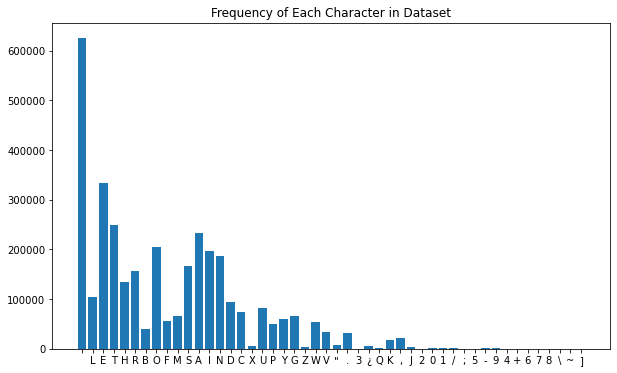

In [41]:
plt.figure(figsize = (10, 6))
plt.bar(text_counter.keys(), text_counter.values())
plt.title('Frequency of Each Character in Dataset');

I will use every character as a predictor based on how much they occur in the sentence.

In [42]:
for ch in text_counter.keys():
    if ch == ' ':
        data['contains__'] = data['sentence'].map(lambda x: x.count(ch))
    else:
        data['contains_' + ch] = data['sentence'].map(lambda x: x.count(ch))

## Modeling

Again, we will use linear regression, a decision tree regressor, a bagging regressor, and a random forest regressor.

In [43]:
# How to get columns that start with a word is taken from here:
# https://mathdatasimplified.com/2020/11/27/pandas-dataframe-how-to-select-all-columns-that-start-with-a-word/

X = data[data.columns[data.columns.str.startswith('contains')]]

In [44]:
y = data['type_time']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [46]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.8205278047488958

In [47]:
lr.score(X_test, y_test)

0.8270927959920755

In [48]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr.score(X_train, y_train)

0.9998102472889395

In [49]:
dtr.score(X_test, y_test)

0.6897310123659264

In [50]:
br = BaggingRegressor()
br.fit(X_train, y_train)
br.score(X_train, y_train)

0.9654909270108931

In [51]:
br.score(X_test, y_test)

0.8228766214932652

In [52]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
rfr.score(X_train, y_train)

0.9768095828183279

In [53]:
rfr.score(X_test, y_test)

0.8384773502280679

The random forest regressor is the best for modeling the impact of one character on typing time, even though the model is overfit.

In [54]:
coef = pd.DataFrame(rfr.feature_importances_, columns = ['coef'], index = X.columns)

In [55]:
coef.sort_values('coef', ascending=False).head(10)

,coef
contains__,0.755172
contains_E,0.023510
contains_I,0.018309
contains_O,0.014869
contains_T,0.014404
contains_R,0.014265
contains_A,0.013518
contains_S,0.013001
contains_N,0.011937
contains_L,0.010079


The number of spaces is easily the most important feature in the model, but the ten most common letters (aside from H) also have a significant effect on typing time.

## Multicollinearity Checking

In [56]:
X['length'] = data['length']

<ipython-input-56-742100e577dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['length'] = data['length']


Text(0.5, 1.0, 'Multicollinearity Heatmap')

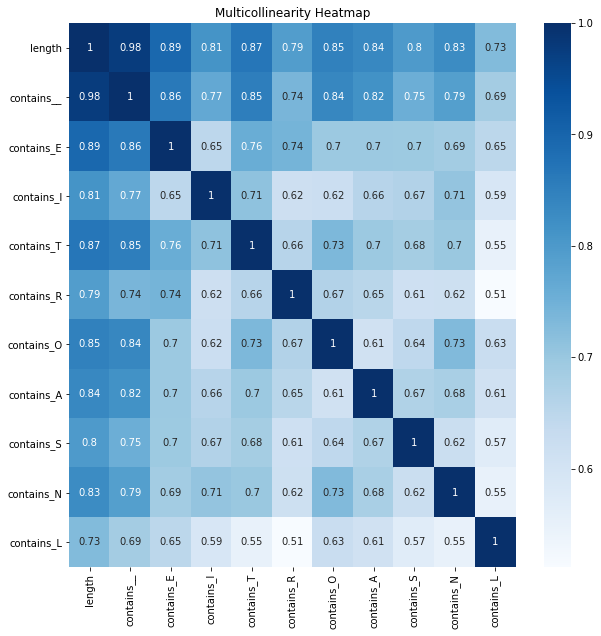

In [57]:
# Checking for multicollinearity between the "contains" variables and length
corr = X[['length', 'contains__', 'contains_E', 'contains_I', 'contains_T', 'contains_R', 
          'contains_O', 'contains_A', 'contains_S', 'contains_N', 'contains_L']].corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corr, annot = True, cmap = 'Blues')
plt.title("Multicollinearity Heatmap")

The length and "contains spaces" variables have high correlation with the top letter variables, but the top letter variables do not have very high correlation with each other. Length and "contains spaces" can be removed to prevent multicollinearity.

In [58]:
data_new = pd.read_csv('../data/data_with_sentiment.csv')

# We will put the 9 most important words into our final dataframe
for ch in ['E', 'I', 'T', 'R', 'O', 'A', 'S', 'N', 'L']:
    data_new['contains_' + ch] = data_new['sentence'].map(lambda x: x.count(ch))

In [59]:
data_new.to_csv('../data/data_with_letters.csv')